In [1]:
import os
import time
import torch
import torchvision
import torchsummary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from keras.datasets.mnist import load_data
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
from numpy.random import randn
import matplotlib.pyplot as plt
import pytorch_lightning as pl

In [3]:
print("Device Count: ",torch.cuda.device_count())
print("Device Name: ",torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Device Count:  1
Device Name:  NVIDIA GeForce GTX 1050 Ti
cuda:0


In [4]:
def generate_real_images(dataset,n_samples):
    """This function returns sample of real images from the dataset."""

    ix= randint(0,dataset.shape[0],n_samples)
    
    X=dataset[ix].astype('float32')
    X=X/255
    X=-1+2*X
    
    y=np.ones((n_samples,1))
    
    return X,y

In [5]:
def generate_latent_points(latent_dim,n_samples):
    """This function returns a sample of latent space vectors."""
    
    X=randn(n_samples,latent_dim)
    y=np.ones((n_samples,1))
    
    return X

In [6]:
def generate_fake_images(n_samples):
    """This function generates fake images to train the discriminator.
        However this function is not used to train the discriminator while actual GAN training."""

    X= np.random.normal(0,1,1*28*28*n_samples)
    X=X.reshape((n_samples,28,28,1))
    X=(X-np.min(X))/(np.max(X)-np.min(X))
    X=-1+2*X
    
    y=np.zeros((n_samples,1))
    
    return X,y

In [7]:
def plot_gen_random(model,n_samples,name,show=False):
    
    """This function is used to plot generated images from a GAN model after training.
        Images generated are purely random, as random vector is drawn from latent space."""

    
    #     X,y_r=generate_real_images(cifar_train[0],n_samples=n_samples)
    X=model(torch.tensor(generate_latent_points(100,n_samples).reshape(-1,100,1,1)).type(torch.float32).to(device))
    X=X.detach().to("cpu")
    fig,ax=plt.subplots(7,7,figsize=(10,10))

    for i in range(49):
        
        x=X[i].permute(2,1,0)
        ax[i//7][i%7].imshow((x+1)/2)
        ax[i//7][i%7].set_xticks([])
        ax[i//7][i%7].set_yticks([])

    fig.tight_layout()
#     fig.savefig(r"C:\Users\abhij\Desktop\IDP\GANs\GANPlots\MNIST\Generator training\\"+name)


In [8]:
def plot_disc_gen_fix(gen,disc,X_lat_fix,X_real_fix,name,show=False):
    
    """This function is used to plot generated images from a generator model using fixed latent points & 
        fixed real images in training dataset. 
        Alongwith the images, title of the images shows the output probability from Discriminator 
        (real images output probability as 1, fake images tends to have probabilities closed to 0)."""
    
    fig,ax=plt.subplots(4,4,figsize=(10,10))

    j=0
    k=0
    X_gen_fix=gen(torch.tensor(X_lat_fix).reshape(-1,100,1,1).type(torch.float32).to(device))
    y_gen=disc(X_gen_fix).detach()
    y_disc=disc(X_real_fix).detach()
    
    for i in range(16):
        if i%4<2:
            x=X_gen_fix[j]
            y=y_gen[j]
            x=x.detach().to("cpu").permute(2,1,0)
            j+=1
            ax[i//4][i%4].set_title("D(G(x))={:.4f}".format(y.item()),fontsize=10)
        else:
            x=X_real_fix[k]
            y=y_disc[k]
            x=x.detach().to("cpu").permute(2,1,0)
            k+=1
            ax[i//4][i%4].set_title("D(x)={:.4f}".format(y.item()),fontsize=10)
        ax[i//4][i%4].imshow((x+1)/2)
        ax[i//4][i%4].set_yticks([])
        ax[i//4][i%4].set_xticks([])

    fig.tight_layout()    
#     fig.savefig(r"C:\Users\abhij\Desktop\IDP\GANs\GANPlots\MNIST\Fix Plots\\"+name)


In [9]:
mnist_train,mnist_test=load_data()

In [10]:
nc=1
nf=28

In [11]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(nc, nf, kernel_size=4,padding=2,stride=2,bias=False)

        self.conv2 = nn.Conv2d(nf,nf*2, kernel_size=4,padding=2,stride=2,bias=False)
        self.batch_norm2 = nn.BatchNorm2d(nf*2)
        
        self.conv3 = nn.Conv2d(nf*2,nf*2*2, kernel_size=4,padding=2,stride=2,bias=False)
        self.batch_norm3 = nn.BatchNorm2d(nf*2*2)
        
        self.conv4 =  nn.Conv2d(nf*2*2,nf*2*2*2, kernel_size=4,padding=2,stride=2,bias=False)
        self.batch_norm4 = nn.BatchNorm2d(nf*2*2*2)
        
        self.conv5 =  nn.Conv2d(nf*2*2*2,1, kernel_size=3,bias=False)

        
  
    def forward(self, x):
        

        x = F.leaky_relu(self.conv1(x),0.2,inplace=True)
        
        x = F.leaky_relu(self.conv2(x),0.2,inplace=True)
        x = self.batch_norm2(x)
        
        x = F.leaky_relu(self.conv3(x),0.2,inplace=True)
        x = self.batch_norm3(x)
        
        x = F.leaky_relu(self.conv4(x),0.2,inplace=True)
        x = self.batch_norm4(x)
        
        x = F.leaky_relu(self.conv5(x),0.2,inplace=True)

        
        
        return torch.sigmoid(x).reshape(-1,1)

In [12]:
D=Discriminator().to(device)
torchsummary.summary(D,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 15, 15]             448
            Conv2d-2             [-1, 56, 8, 8]          25,088
       BatchNorm2d-3             [-1, 56, 8, 8]             112
            Conv2d-4            [-1, 112, 5, 5]         100,352
       BatchNorm2d-5            [-1, 112, 5, 5]             224
            Conv2d-6            [-1, 224, 3, 3]         401,408
       BatchNorm2d-7            [-1, 224, 3, 3]             448
            Conv2d-8              [-1, 1, 1, 1]           2,016
Total params: 530,096
Trainable params: 530,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.18
Params size (MB): 2.02
Estimated Total Size (MB): 2.20
----------------------------------------------------------------


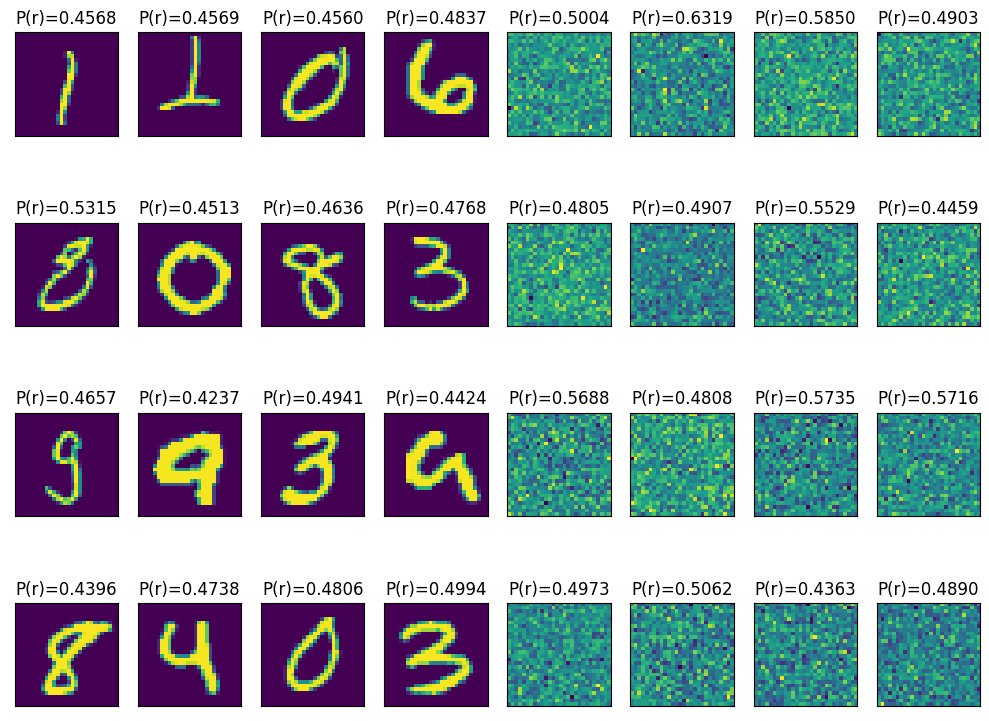

In [13]:
X_r,y_r=generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_samples=16)
X_f,y_f=generate_fake_images(n_samples=16)

p_X_r=D(torch.tensor(X_r).permute(0,3,2,1).type(torch.float32).to(device))
p_X_f=D(torch.tensor(X_f).permute(0,3,2,1).type(torch.float32).to(device))

fig,ax=plt.subplots(4,8,figsize=(10,8))

for i in range(16):
    
    # Plotting real images alongwith the Discriminator ouput as title !
    ax[i//4][i%4].set_title("P(r)={:.4f}".format(p_X_r[i].detach().item()))
    ax[i//4][i%4].imshow((X_r[i]+1)/2)
    ax[i//4][i%4].set_xticks([])
    ax[i//4][i%4].set_yticks([])
    
    # Plotting fake images alongwith the Discriminator ouput as title !
    ax[i//4][i%4+4].set_title("P(r)={:.4f}".format(p_X_f[i].detach().item()))
    ax[i//4][i%4+4].imshow((X_f[i]+1)/2)
    ax[i//4][i%4+4].set_xticks([])
    ax[i//4][i%4+4].set_yticks([])
    
fig.tight_layout()
plt.show()

### Training the Discriminator to check if it's able to identify real/fake images...
- Setting Optimizer
- Setting Loss Function
- Defining a Training loop
    - Trained for 1 epoch only.
        - In 1 epoch discriminator will see 60000 real images and 60000 fake images. Therefore, it is easy for discriminator to learn the difference between the two quickly.
    - 600 iterations in 1 epoch.
        - In each iteration, real images are sampled from training dataset and fake images are generated using **generate_fake_images** function.
    - Labels for real images (y_real) are marked as 1 & for fake images (y_fake) as 0.
        

#### Optimizer and Loss Function

In [14]:
optimizer= torch.optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))
criterion= nn.BCELoss()

In [15]:
# Loop parameters (Batchsize, n_epochs)
n_epochs=1
n_batch_size=100
steps= int(mnist_train[0].shape[0]/n_batch_size)

for epoch in range(n_epochs):
    start=time.time()
    for step in range(steps):
        
        
        optimizer.zero_grad()
        
        
        # Randomly sampling real images from training dataset.. !
        X_real, y_real = generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_batch_size)
        X_real, y_real = torch.tensor(X_real).type(torch.float32).to(device),torch.tensor(y_real).type(torch.float32).to(device)
    
        
        # Forward pass to Discriminator using Real Images as input..
        output_real = D(X_real.permute(0,3,2,1))
        
        # Computing the loss on real images & Making a backward pass to store gradients...
        real_loss = criterion(output_real.view(n_batch_size,-1),y_real)
        real_loss.backward()
        
        
        # Generating random fake images using predefined function.. !
        X_fake, y_fake = generate_fake_images(n_batch_size)
        X_fake, y_fake = torch.tensor(X_fake).type(torch.float32).to(device),torch.tensor(y_fake).type(torch.float32).to(device)
        
        
        # Forward pass to Discriminator using Fake Images as input..
        output_fake = D(X_fake.permute(0,3,2,1))
        
        # Computing the loss on fake images & Making a backward pass to store gradients...
        fake_loss = criterion(output_fake.view(n_batch_size,-1),y_fake)
        fake_loss.backward()
        
        
        # Calling step at the end of each iteration, to update the gradients of Discriminator trained on both real&fake image...!
        optimizer.step()
        
        
        if step%50==0:
            
            print("Epoch {}/{} | Step {}/{}, Real Loss: {:4f} //  Fake Loss: {:4f}".format(epoch,n_epochs,int(step/50),int(steps/50),real_loss.detach(),fake_loss.detach()))
    
    print("Time for current epoch: {}".format(time.time()-start))

Epoch 0/1 | Step 0/12, Real Loss: 0.740695 //  Fake Loss: 0.803313
Epoch 0/1 | Step 1/12, Real Loss: 0.000341 //  Fake Loss: 0.024614
Epoch 0/1 | Step 2/12, Real Loss: 0.000091 //  Fake Loss: 0.008717
Epoch 0/1 | Step 3/12, Real Loss: 0.000016 //  Fake Loss: 0.006191
Epoch 0/1 | Step 4/12, Real Loss: 0.000025 //  Fake Loss: 0.003564
Epoch 0/1 | Step 5/12, Real Loss: 0.000004 //  Fake Loss: 0.002521
Epoch 0/1 | Step 6/12, Real Loss: 0.000000 //  Fake Loss: 0.002090
Epoch 0/1 | Step 7/12, Real Loss: 0.000003 //  Fake Loss: 0.001790
Epoch 0/1 | Step 8/12, Real Loss: 0.000012 //  Fake Loss: 0.001471
Epoch 0/1 | Step 9/12, Real Loss: 0.000020 //  Fake Loss: 0.001163
Epoch 0/1 | Step 10/12, Real Loss: 0.000000 //  Fake Loss: 0.000865
Epoch 0/1 | Step 11/12, Real Loss: 0.000001 //  Fake Loss: 0.000736
Time for current epoch: 10.60463547706604


### Verifying the results of trained Discriminator by checking the classification of some sample real & fake images...!

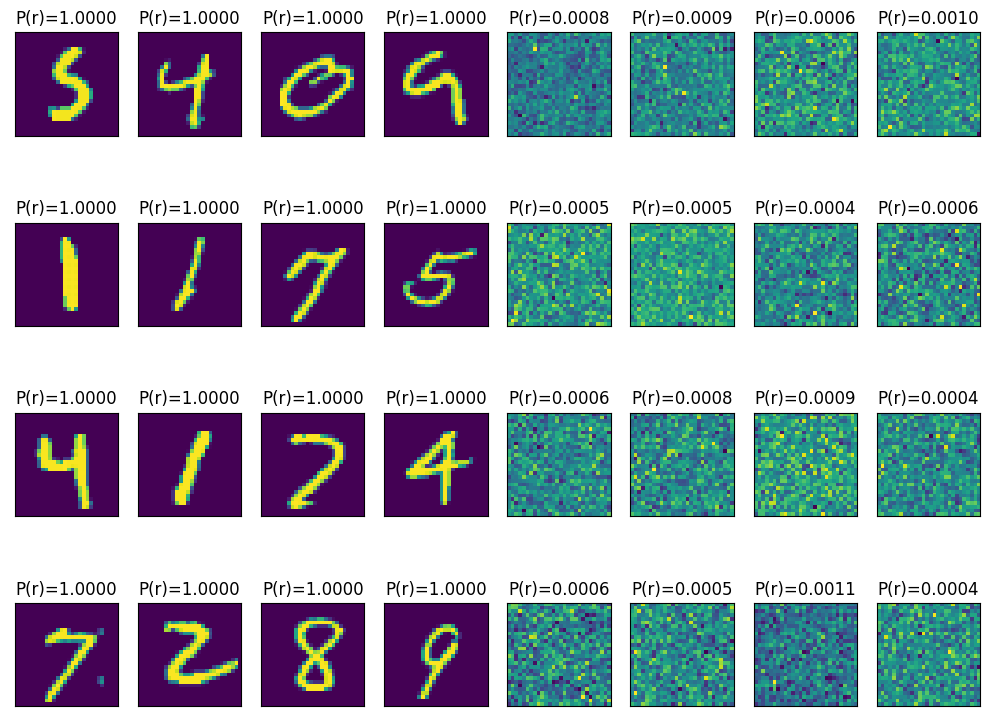

In [16]:
# Preparing input data for Discriminator  (Real & Fake Images alongwith labels (1&0, respectively))..
X_r,y_r=generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_samples=16)
X_f,y_f=generate_fake_images(n_samples=16)

# Getting the predictions on sample by making a forward pass to a Discriminator..
p_X_r=D(torch.tensor(X_r).permute(0,3,2,1).type(torch.float32).to(device))
p_X_f=D(torch.tensor(X_f).permute(0,3,2,1).type(torch.float32).to(device))



# Plotting the results...
fig,ax=plt.subplots(4,8,figsize=(10,8))

for i in range(16):
    
    # Plotting real images alongwith the Discriminator ouput as title !
    ax[i//4][i%4].set_title("P(r)={:.4f}".format(p_X_r[i].detach().item()))
    ax[i//4][i%4].imshow((X_r[i]+1)/2)
    ax[i//4][i%4].set_xticks([])
    ax[i//4][i%4].set_yticks([])
    
    # Plotting fake images alongwith the Discriminator ouput as title !
    ax[i//4][i%4+4].set_title("P(r)={:.4f}".format(p_X_f[i].detach().item()))
    ax[i//4][i%4+4].imshow((X_f[i]+1)/2)
    ax[i//4][i%4+4].set_xticks([])
    ax[i//4][i%4+4].set_yticks([])
    
fig.tight_layout()
plt.show()

- We can see that our Discriminator is able to correctly identify the real & fake images.
    - Discriminator outputs the probability of image being real.
    - Therefore, for real images we can see that output is close to 1, whereas for fake images the outputs are close to 0.

In [17]:
class Generator(nn.Module):
    
    def __init__(self,latent_dim):
        super().__init__()

        
        self.convT0=nn.ConvTranspose2d(latent_dim, nf*8, kernel_size=4,stride=2,padding=1,bias=False)
        self.batch_norm0=nn.BatchNorm2d(nf*8)
        
        self.convT1=nn.ConvTranspose2d(nf*8, nf*4, kernel_size=4,stride=2,padding=1,bias=False)
        self.batch_norm1=nn.BatchNorm2d(nf*4)
        
        self.convT2=nn.ConvTranspose2d(nf*4, nf*2, kernel_size=4,stride=2,padding=1,bias=False)
        self.batch_norm2=nn.BatchNorm2d(nf*2)
        
        self.convT3=nn.ConvTranspose2d(nf*2, nf, kernel_size=4,stride=2,padding=1,bias=False)
        self.batch_norm3=nn.BatchNorm2d(nf)
        
        self.convT4=nn.ConvTranspose2d(nf, nc, kernel_size=4,stride=2,padding=1,bias=False)
        self.batch_norm4=nn.BatchNorm2d(nc)
        
        self.convT5=nn.Conv2d(nc, nc, kernel_size=5,stride=1,padding=0,bias=False)
        
        
    
    def forward(self, x):
        
        
        x = F.relu(self.convT0(x),inplace=True)
        x = self.batch_norm0(x)
        
        x = F.relu(self.convT1(x),inplace=True)
        x = self.batch_norm1(x)
        
        x = F.relu(self.convT2(x),inplace=True)
        x = self.batch_norm2(x)
        
        x = F.relu(self.convT3(x),inplace=True)
        x = self.batch_norm3(x)
        
        x = self.convT4(x)
        x = self.batch_norm4(x)
        
        x = self.convT5(x)

        
        return torch.tanh(x)

In [18]:
G=Generator(100)
torchsummary.summary(G,(100,1,1),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 224, 2, 2]         358,400
       BatchNorm2d-2            [-1, 224, 2, 2]             448
   ConvTranspose2d-3            [-1, 112, 4, 4]         401,408
       BatchNorm2d-4            [-1, 112, 4, 4]             224
   ConvTranspose2d-5             [-1, 56, 8, 8]         100,352
       BatchNorm2d-6             [-1, 56, 8, 8]             112
   ConvTranspose2d-7           [-1, 28, 16, 16]          25,088
       BatchNorm2d-8           [-1, 28, 16, 16]              56
   ConvTranspose2d-9            [-1, 1, 32, 32]             448
      BatchNorm2d-10            [-1, 1, 32, 32]               2
           Conv2d-11            [-1, 1, 28, 28]              25
Total params: 886,563
Trainable params: 886,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### Using the Generator to generate fake images & Verifying that if our Discriminator can identify those as fake images or not...

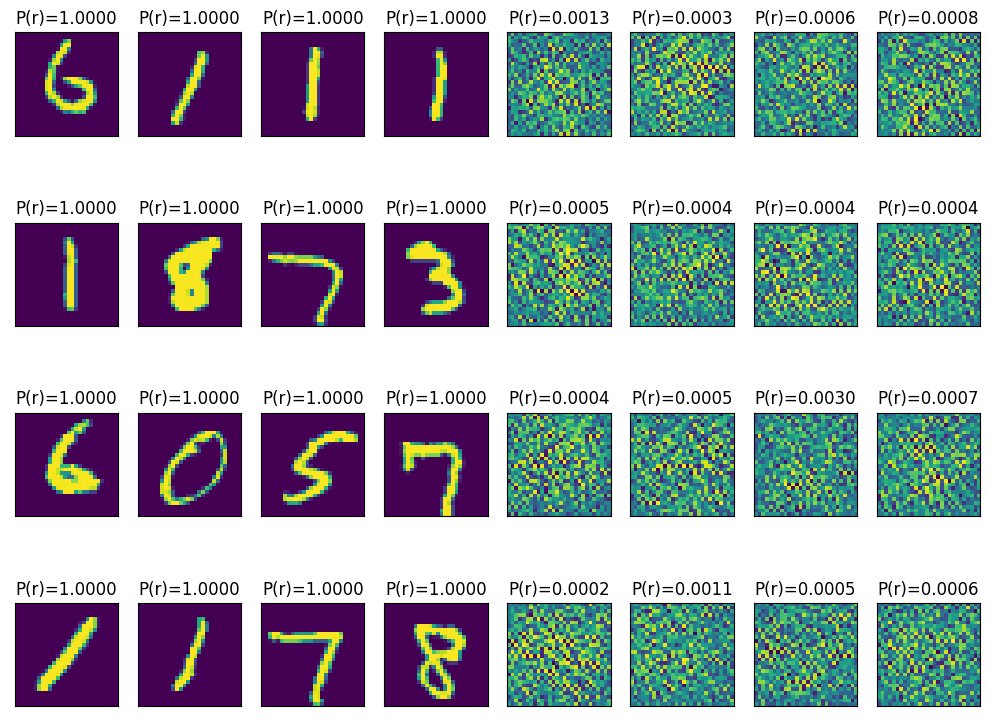

In [19]:
n_samples= 16
latent_dim= 100


# Preparing input data for Discriminator  
## Real images sampled from training data
X_r,y_r=generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_samples=n_samples)
## Fake images are generated by Generator
X_f=G(torch.tensor(generate_latent_points(latent_dim,n_samples).reshape(-1,latent_dim,1,1)).type(torch.float32))


# Getting the predictions on sample by making a forward pass to a Discriminator..
p_X_r=D(torch.tensor(X_r).permute(0,3,2,1).type(torch.float32).to(device))
p_X_f=D(X_f.to(device).clone())

# Plotting the results...
fig,ax=plt.subplots(4,8,figsize=(10,8))

for i in range(16):
    
    # Plotting real images, alongwith the Discriminator ouput as title !
    ax[i//4][i%4].set_title("P(r)={:.4f}".format(p_X_r[i].item()))
    ax[i//4][i%4].imshow((X_r[i]+1)/2)
    ax[i//4][i%4].set_xticks([])
    ax[i//4][i%4].set_yticks([])
    
    # Plotting generated images from generator, alongwith the Discriminator ouput as title !
    ax[i//4][i%4+4].set_title("P(r)={:.4f}".format(p_X_f[i].item()))
    ax[i//4][i%4+4].imshow((X_f[i].detach().reshape(28,28,1)+1)/2)
    ax[i//4][i%4+4].set_xticks([])
    ax[i//4][i%4+4].set_yticks([])
    
fig.tight_layout()
plt.show()

- We can see that our Discriminator is able to correctly identify the real & fake images (generated images).

## Training a GAN model...!

In [20]:
latent_dim= 100
gen=Generator(latent_dim)
optimizer_gen=torch.optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5, 0.999))

In [21]:
disc=Discriminator()
optimizer_disc=torch.optim.Adam(disc.parameters(),lr=0.0002,betas=(0.5, 0.999))

In [22]:
criterion=nn.BCELoss()

In [23]:
gen=gen.to(device)
disc=disc.to(device)

In [24]:
disc_real_loss=[]
disc_fake_loss1=[]
disc_fake_loss2=[]
disc_real_prob=[]
disc_fake_prob_bu=[]
disc_fake_prob_au=[]

# Loop parameters (Batchsize, n_epochs)
n_epochs=10
n_batch_size=100
n_steps=int(mnist_train[0].shape[0]//n_batch_size)


# Creating a separate set of real & fake images, on which we can track the progression of learning for both the models..
X_lat_fix=generate_latent_points(latent_dim,n_batch_size)
X_real_fix,y=generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_batch_size)
X_real_fix=torch.Tensor(X_real_fix).permute(0,3,2,1).to(device)
X_real_fix=torch.Tensor(X_real_fix).to(device)


for epoch in range(n_epochs):
    start=time.time()
    for step in range(n_steps):
        
        # Randomly sampling real images from training dataset & label for those images is set to 1.. !
        X_real,y_real=generate_real_images(mnist_train[0].reshape(60000,28,28,1),n_batch_size)
        X_real,y_real=torch.Tensor(X_real).permute(0,3,2,1).to(device),torch.Tensor(y_real).to(device)
        
        # Generating random latent vectors and feeding to generator to get fake images & label for those images is set to 0.. !
        X_lat=generate_latent_points(latent_dim,n_batch_size)
        X_fake,y_fake=gen(torch.tensor(X_lat.reshape(n_batch_size,latent_dim,1,1)).type(torch.float32).to(device)),np.zeros((n_batch_size,1))
        X_fake,y_fake=X_fake,torch.Tensor(y_fake).to(device)
        
        
        
        # Setting all the previous gradients of Discriminator to zero for current iteration..!
        optimizer_disc.zero_grad()

        
        # Forward pass to Discriminator using Real Images as input.. [D(x)]
        output_real=disc(X_real)
        
        # Computing the loss on real images & Making a backward pass to store gradients... 
        real_loss=criterion(output_real.view(n_batch_size,-1),y_real)
        disc_real_prob.append(output_real.mean().item())
        disc_real_loss.append(real_loss.item())
        real_loss.backward(retain_graph=True)


        ######################################


        # Forward pass to Discriminator using Fake Images (generated by Generator) as input.. [D(G(x))_1]
        output_fake=disc(X_fake)  
        
        # Computing the loss on fake images & Making a backward pass to store gradients...
        fake_loss=criterion(output_fake.view(n_batch_size,-1),y_fake)
        disc_fake_prob_bu.append(output_fake.mean().item())
        disc_fake_loss1.append(fake_loss.item())
        fake_loss.backward(retain_graph=True)

        
        # Computing total loss for a Discriminator on real & fake images...!
        disc_loss= (real_loss+fake_loss)
        
        # Calling step for current iteration, to update the gradients of Discriminator trained on both real&fake image...!
        optimizer_disc.step()
        
        
        #####################################################################################        

        
        # Setting all the previous gradients of Generator to zero for current iteration..!
        optimizer_gen.zero_grad()
        
        # Using the fake images generated by Generator for Discriminator & passing to Discriminaotor, label for those images is set to 1 here.. !
        X_gen,y_gen=X_fake,np.ones((n_batch_size,1))
        X_gen,y_gen=X_gen,torch.Tensor(y_gen).to(device)
        
        # Forward pass to Discriminator using Fake Images (generated by Generator) as input.. [D(G(x))_2]
        output_gen=disc(X_gen)
        
        # Computing the loss on fake images, using 1 as label for those & Making a backward pass to store gradients for generator...
        gen_loss=criterion(output_gen.view(n_batch_size,-1).type(torch.float32),y_gen.type(torch.float32))
        disc_fake_prob_au.append(output_gen.mean().item())
        disc_fake_loss2.append(gen_loss.item())
        gen_loss.backward(retain_graph=True)
        
        
        # Calling step for current iteration, to update the gradients of Generator against the updated Discrimintor...!
        optimizer_gen.step()
        
        
        #####################################################################################
        
        # Printing the training progress at each 50th iteration...!
        if step%50==0:
            print("Epoch {}/{} | Step {}/{}, Real Loss: {:.3f} //  Fake Loss: {:.3f} //  GAN Loss: {:.3f}".format(epoch,n_epochs,int(step/50),int(n_steps/50),real_loss.detach(),fake_loss.detach(),gen_loss.detach()))
        
        

###############################################################################################
    # Plotting the images generated by Generator after training, at each 10th epoch...!

        
       
#     plot_gen_random(gen,49,"Epoch"+str(epoch))
#     plot_disc_gen_fix(gen,disc,X_lat_fix,X_real_fix,"Epoch"+str(epoch))
    
    print("Time for current epoch: {}".format(time.time()-start))
    print("-"*45)

Epoch 0/10 | Step 0/12, Real Loss: 0.676 //  Fake Loss: 0.778 //  GAN Loss: 0.779
Epoch 0/10 | Step 1/12, Real Loss: 0.000 //  Fake Loss: 0.025 //  GAN Loss: 3.806
Epoch 0/10 | Step 2/12, Real Loss: 0.000 //  Fake Loss: 0.018 //  GAN Loss: 4.351
Epoch 0/10 | Step 3/12, Real Loss: 0.025 //  Fake Loss: 0.100 //  GAN Loss: 3.224
Epoch 0/10 | Step 4/12, Real Loss: 0.297 //  Fake Loss: 0.240 //  GAN Loss: 1.066
Epoch 0/10 | Step 5/12, Real Loss: 1.764 //  Fake Loss: 0.071 //  GAN Loss: 2.162
Epoch 0/10 | Step 6/12, Real Loss: 0.179 //  Fake Loss: 0.252 //  GAN Loss: 1.163
Epoch 0/10 | Step 7/12, Real Loss: 0.001 //  Fake Loss: 0.723 //  GAN Loss: 3.816
Epoch 0/10 | Step 8/12, Real Loss: 0.080 //  Fake Loss: 0.288 //  GAN Loss: 1.602
Epoch 0/10 | Step 9/12, Real Loss: 0.656 //  Fake Loss: 0.072 //  GAN Loss: 2.437
Epoch 0/10 | Step 10/12, Real Loss: 0.056 //  Fake Loss: 0.457 //  GAN Loss: 2.454
Epoch 0/10 | Step 11/12, Real Loss: 0.077 //  Fake Loss: 0.568 //  GAN Loss: 0.916
Time for curre

Epoch 7/10 | Step 9/12, Real Loss: 0.107 //  Fake Loss: 0.065 //  GAN Loss: 2.086
Epoch 7/10 | Step 10/12, Real Loss: 0.041 //  Fake Loss: 0.073 //  GAN Loss: 2.845
Epoch 7/10 | Step 11/12, Real Loss: 0.001 //  Fake Loss: 0.167 //  GAN Loss: 2.646
Time for current epoch: 27.461881160736084
---------------------------------------------
Epoch 8/10 | Step 0/12, Real Loss: 0.080 //  Fake Loss: 0.092 //  GAN Loss: 1.951
Epoch 8/10 | Step 1/12, Real Loss: 0.028 //  Fake Loss: 0.044 //  GAN Loss: 3.237
Epoch 8/10 | Step 2/12, Real Loss: 0.003 //  Fake Loss: 0.076 //  GAN Loss: 3.332
Epoch 8/10 | Step 3/12, Real Loss: 0.001 //  Fake Loss: 0.143 //  GAN Loss: 2.667
Epoch 8/10 | Step 4/12, Real Loss: 0.000 //  Fake Loss: 2.138 //  GAN Loss: 6.874
Epoch 8/10 | Step 5/12, Real Loss: 0.027 //  Fake Loss: 0.068 //  GAN Loss: 2.754
Epoch 8/10 | Step 6/12, Real Loss: 0.001 //  Fake Loss: 0.175 //  GAN Loss: 2.552
Epoch 8/10 | Step 7/12, Real Loss: 0.004 //  Fake Loss: 0.098 //  GAN Loss: 2.758
Epoch 8

### GAN Loss and Probability output Plots...

In [25]:
from operator import add
x=list(map(add,disc_real_loss,disc_fake_loss1))

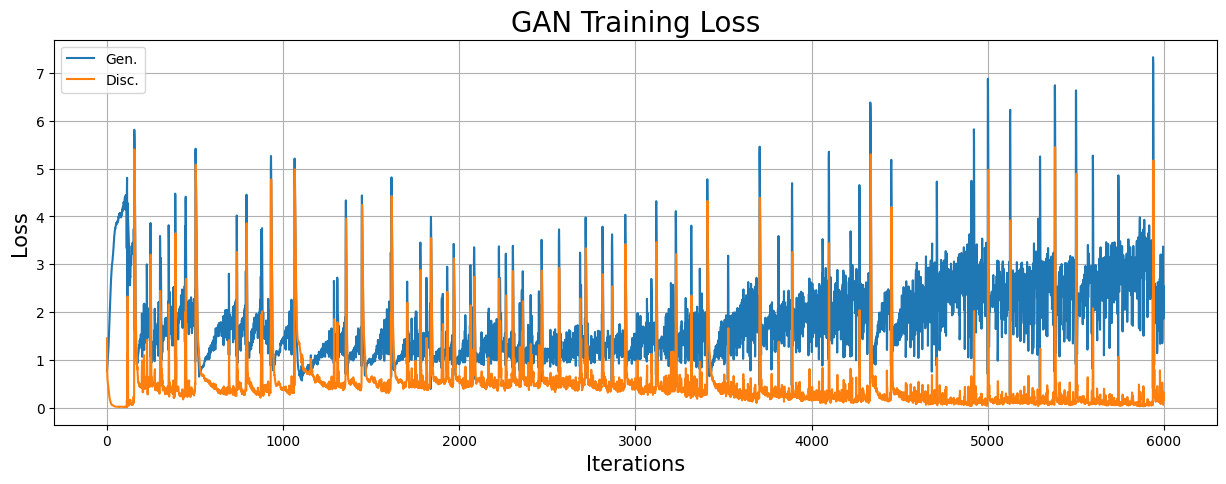

In [29]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(disc_fake_loss2[:10000])
ax.plot(x[:10000])
plt.legend(['Gen.','Disc.'])
plt.title('GAN Training Loss',fontsize=20)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Iterations',fontsize=15)
# ax.set_xticks([i for i in range(500)])
ax.grid(True)
plt.show()

**Above figure shows the plot between loss for Generator and Discriminator model.**

- We can see that between 1000 to 3000 iterations, loss for generator is decreasing and then tends to increase towards end. Therefore, training GANs beyond 3000 iterations may not yield useful results while using the current architecture.
- Also, we can see that loss for Discriminator model is higher comparitvely. Therefore, our Discriminator is confused most during these iterations by generator.
    - Beyond 3000 iterations, discriminator is able to identify fake images generated by generator and it cannot fool the discriminator anymore.

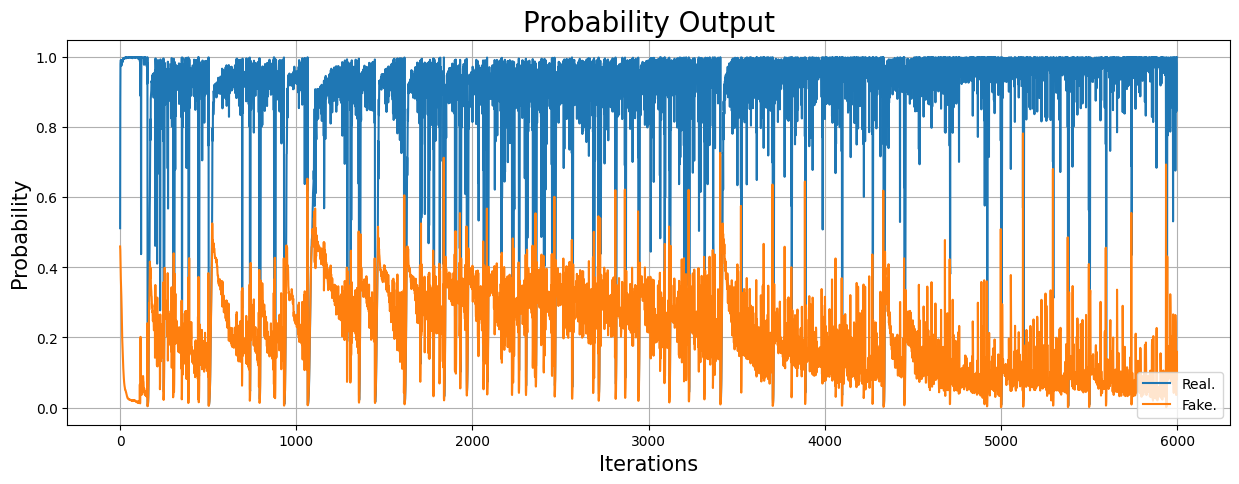

In [30]:
fig,ax=plt.subplots(1,1,figsize=(15,5))
ax.plot(disc_real_prob[:10000])
ax.plot(disc_fake_prob_au[:10000])
# ax.plot(disc_fake_prob_bu[:500])
ax.legend(['Real.','Fake.'],loc='lower right')
plt.title('Probability Output',fontsize=20)
plt.ylabel('Probability',fontsize=15)
plt.xlabel('Iterations',fontsize=15)
# ax.set_xticks([i for i in range(500)])
ax.grid(True)
plt.show()

**Above figure shows the plot between probabilites(mean) of Discriminator model.**

- ***Blue line*** represents the mean probability assigned by Discriminator to the real images.
- ***Orange line*** represents the mean probability assigned by Discriminator to the generated fake images (afte Discriminator gets updated).
- From the above plot we can infer that Generator is able to confuse the Discriminator most between 1000 to 3000 iterations.
    - As the output probabilities decreases for real images and increases for fake images.

---------------